Training from several snapshots of data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def in_out(auxhist, wrfout): #outputs the required input and output data from the auxhist and wrfout files
    DS_a = xr.open_dataset(auxhist) #dataset of auxhist
    DS_w = xr.open_dataset(wrfout) #dataset of wrfout
    
    T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
    st = DS_w.TSK.values #surface temp
    d_c = DS_w.TAU_OD.values #dust optical depth
    em = DS_w.EMISS.values #emissivity
    p = DS_w.P.values + DS_w.PB.values #pressure
    uif = DS_a.UPIRFLUX.values[1:,:,:,:] 

    temp_uif = []
    for i in range(52):
        temp_uif.append(uif[:,i,:,:].reshape(-1))
    uif = np.array(temp_uif).T
    uif.shape


    sla = [] #special layer arrays that are the feature vectors in the linear regression model
    sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
    for i in range(52): #using all the layers now
        sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52): #using all the layers now
        sla.append((np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    sla = np.array(sla)
    sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)
    
    return sla, uif

In [3]:
sla1, uif1 = in_out('af', 'wf')  #first snapshot of data (0001-00001)

In [4]:
sla2, uif2 = in_out('af2', 'wf2') #some snapshot of data about half a martian year later (0002-00352)

In [5]:
sla3, uif3 = in_out('af3', 'wf3') #this will be the test set (0002-00472)

In [6]:
uif_train = np.concatenate((uif1, uif2), axis=0) #total uif for training

In [7]:
sla_train = np.concatenate((sla1, sla2), axis=0) #total sla for training

In [8]:
uif3.shape

(619488, 52)

# Linear regression

In [9]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(sla_train,uif_train)
uif_lin = lr1.predict(sla3) 

In [10]:
lr1.coef_

array([[ 3.60194932e-08,  2.46397693e-08, -1.32692435e-08, ...,
         1.29606610e-06, -1.16232604e-06,  2.54709789e-06],
       [ 3.60194612e-08,  2.46397622e-08, -1.32692684e-08, ...,
         1.29605166e-06, -1.16232729e-06,  2.54704560e-06],
       [ 3.60194576e-08,  2.46398439e-08, -1.32692319e-08, ...,
         1.29604291e-06, -1.16232889e-06,  2.54700717e-06],
       ...,
       [ 4.23115765e-08,  2.16631211e-08, -1.02497939e-08, ...,
         1.15026978e-06, -8.71065140e-07,  1.67782730e-07],
       [ 4.26006004e-08,  2.21642722e-08, -1.03899449e-08, ...,
         1.14957618e-06, -8.65652112e-07,  1.10632605e-07],
       [ 4.29927098e-08,  2.30089956e-08, -1.02945208e-08, ...,
         1.14830618e-06, -8.57663565e-07,  3.84122529e-08]], dtype=float32)

In [11]:
from sklearn.metrics import mean_squared_error
uif_out = uif3
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

8.903567

In [12]:
np.min(uif_out)

15.713927

In [13]:
np.max(uif_out)

484.24545

In [14]:
uif_diff = uif_out - uif_lin

In [15]:
np.where(uif_diff > 50)

(array([  6705,   6705,   6705, ..., 597681, 597681, 597681], dtype=int64),
 array([ 0,  1,  2, ..., 49, 50, 51], dtype=int64))

<function matplotlib.pyplot.show(*args, **kw)>

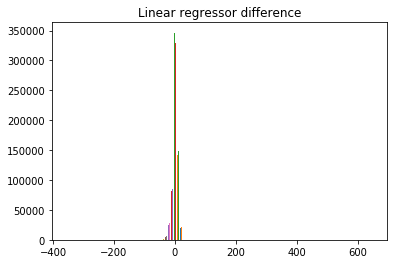

In [16]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [17]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [18]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

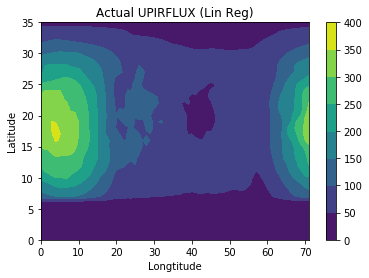

In [19]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

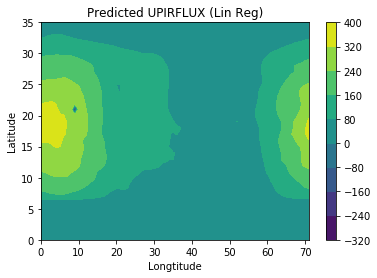

In [20]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

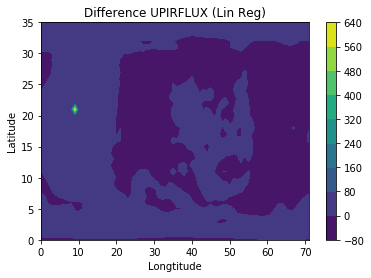

In [21]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

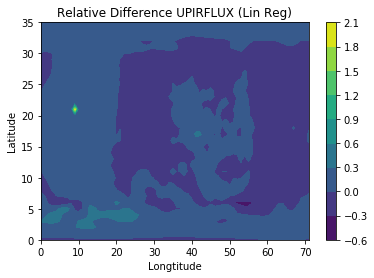

In [22]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [23]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [24]:
real_out.shape

(36, 72)

In [25]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [26]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[-0.33442565,  0.07844177,  0.00815218, ..., -0.31154014,
        -0.07070355,  0.41729759],
       [-0.33432957,  0.07852678,  0.00823428, ..., -0.31145975,
        -0.07061207,  0.41738406],
       [-0.33435356,  0.0785189 ,  0.00820892, ..., -0.31149645,
        -0.07063887,  0.41737155],
       ...,
       [-0.91082212, -1.10639758, -0.62189143, ..., -0.7384043 ,
        -0.44266159, -0.56386899],
       [-0.87246289, -1.10861684, -0.60093635, ..., -0.70015866,
        -0.40449621, -0.56676511],
       [-0.81791643, -1.10684289, -0.57160272, ..., -0.64506325,
        -0.35248971, -0.56788602]])

In [27]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([ 0.4497403 ,  0.4498267 ,  0.44979609,  0.44999513,  0.45013589,
        0.450152  ,  0.45022822,  0.44991548,  0.44956699,  0.44924204,
        0.44929957,  0.44891278,  0.44833532,  0.44793204,  0.44711077,
        0.4455349 ,  0.44367366,  0.44175236,  0.44025024,  0.44042521,
        0.44216689,  0.44812791,  0.45598869,  0.46173595,  0.46226209,
        0.45665757,  0.44519229,  0.42340176,  0.39095852,  0.35271423,
        0.31058669,  0.26055515,  0.20276678,  0.14136199,  0.08196794,
        0.01654331, -0.04669918, -0.08987459, -0.10662995, -0.10780839,
       -0.10683882, -0.1053221 , -0.10310066, -0.09925935, -0.09382401,
       -0.08924112, -0.08368902, -0.07563662, -0.06516175, -0.05154879,
       -0.03340779, -0.00753908])

In [28]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.69486403, -0.69478412, -0.69480905, -0.69479806, -0.69479965,
       -0.69495677, -0.69492454, -0.69499744, -0.69470261, -0.69459144,
       -0.69467197, -0.69513899, -0.69566653, -0.69613186, -0.69718745,
       -0.69894223, -0.70117999, -0.70394395, -0.70670235, -0.7078954 ,
       -0.70704907, -0.70390341, -0.69932663, -0.6973169 , -0.70075951,
       -0.71111012, -0.72795359, -0.75482531, -0.79263484, -0.83965827,
       -0.89253943, -0.9512219 , -1.01430281, -1.0819571 , -1.14371396,
       -1.20710511, -1.27199295, -1.32090405, -1.34367637, -1.34654542,
       -1.34613366, -1.34404612, -1.34116427, -1.33671401, -1.33008522,
       -1.32407324, -1.31623596, -1.30549815, -1.29120014, -1.26964966,
       -1.23539047, -1.18373066])

In [29]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.28818364, 0.28818529, 0.2881873 , 0.28824314, 0.28829861,
       0.28834495, 0.28836203, 0.28831151, 0.28818104, 0.28802479,
       0.28803276, 0.28811589, 0.28817368, 0.28817173, 0.28815733,
       0.28816871, 0.28822658, 0.28833039, 0.2884729 , 0.2886798 ,
       0.28886302, 0.28905104, 0.28935077, 0.28963483, 0.28951802,
       0.2891407 , 0.28853207, 0.28751018, 0.28620718, 0.28542861,
       0.28488444, 0.28366872, 0.28172126, 0.28006563, 0.27732404,
       0.27379336, 0.27241082, 0.27472617, 0.27947953, 0.28173785,
       0.28406738, 0.28540981, 0.28681235, 0.28824847, 0.28973635,
       0.2908858 , 0.29223345, 0.29386686, 0.29596354, 0.29872621,
       0.30224888, 0.30696153])

In [30]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([ 9.83044150e-03,  9.91572364e-03,  9.89166997e-03,  1.00042092e-02,
        1.00378834e-02,  1.00115999e-02,  1.01229199e-02,  9.96857980e-03,
        1.00097968e-02,  9.90353012e-03,  9.85408706e-03,  9.49817892e-03,
        8.98562328e-03,  8.40898340e-03,  7.19686163e-03,  5.32018322e-03,
        3.18916188e-03,  8.28842587e-04, -1.19175784e-03, -1.43214574e-03,
        1.80256683e-04,  3.70734082e-03,  8.51482492e-03,  1.07896911e-02,
        7.15746845e-03, -3.76141219e-03, -2.17245780e-02, -5.03353860e-02,
       -9.02809621e-02, -1.38274497e-01, -1.91814064e-01, -2.51891471e-01,
       -3.18189453e-01, -3.91152983e-01, -4.63292409e-01, -5.38160371e-01,
       -6.10903736e-01, -6.66704335e-01, -6.94248685e-01, -6.99603429e-01,
       -7.01912955e-01, -7.01618549e-01, -7.00458991e-01, -6.97398856e-01,
       -6.92236503e-01, -6.87573327e-01, -6.81656759e-01, -6.73580559e-01,
       -6.62753087e-01, -6.46709714e-01, -6.22443593e-01, -5.87582093e-01])

In [31]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.2501069000963127


These are surprisingly small...